In [2]:
import h5py
from string import Template
import numpy as np
import scipy
import os
from matplotlib import pyplot as plt, cm
#!pip install pyestimate
#from pyestimate import sin_param_estimate
import datetime

def integrate_q(data,q,q_roi, norm_sum):
    """checked by Christian"""
    q_start, q_stop = q_roi
    start_index = np.where(q>=q_start)[0][0]
    stop_index = np.where(q>=q_stop)[0][0]
    azimutal_integrated = np.sum(data[...,start_index:stop_index]*norm_sum[:,start_index:stop_index] ,axis=(2,3))
    norm = np.sum(norm_sum[:,start_index:stop_index], axis=(0,1))
    output = np.divide(azimutal_integrated ,norm , out=np.zeros_like(azimutal_integrated))
    return output

def load_data(proposal,visit,scan, det, fly_scan, cluster='maxiv'):
    """keys in file that will be loaded
        **FROM AZINT FILE**
        'I' : cake plot from radial integration, ordering (image,azimuthal,q) 
        'azi', : azimuthal bins
        'mask_file', : file path for mask used for radial integration
        'norm', : weights/norm sum for computing averages for integrated data, (azimuthal and q)
        'polarization_factor', : polarisation factor used for integration
        'poni_file', : file path for pony file
        'q', : q Vektor for integration
        **FROM MASTER FILE**
        'i_t', : diode data, transmittance for 2D map
        'dt' : exposure time from eiger/lambda/diode
        'title' :  scan command from SPOCK
        'swaxs_x' : swaxs_x stage position (encoder reading)
        'swaxs_y' : swaxs_y stage position (theoretical reading)
        'swaxs_rot' : swaxs_y stage position (theoretical reading)
        'time' : time point for triggers for exposure
    """
    if cluster == 'maxiv':
        fname = '/data/visitors/formax/%s/%s/process/azint/scan-%04d_%s_integrated.h5' %(proposal, visit, scan, det)
    elif cluster == 'lunarc':
        fname = '/projects/maxiv/visitors/formax/%s/%s/process/azint/scan-%04d_%s_integrated.h5' %(proposal, visit, scan, det)
    else:
        print("Clustername is not recognised")
        
    data = {}
    items = {
         'I': 'entry/data2d/cake',
         'q': 'entry/data1d/q',
         'azi' : 'entry/data2d/azi',
         'mask_file':'entry/azint/input/mask_file',
         'norm':'entry/data2d/norm',
         'polarization_factor':'entry/azint/input/polarization_factor',
         'poni':'entry/azint/input/poni',   
    }
    with h5py.File(fname, 'r') as fh:
        for key, name in items.items():
            if name in fh:
                data[key] = fh[name][()]  
            
    # master file
    master = fname.replace('process/azint', 'raw')
    master = master.replace('_%s_integrated' %det, '')
    items = {
        'i_t': 'entry/instrument/albaem-e01_ch1/data',   
         'title': 'entry/title'                       
    }
    with h5py.File(master, 'r') as fh:
        for key, name in items.items():
            if name in fh:
                data[key] = fh[name][()]

    # fly or step scan
    if fly_scan == True:
        data['shape'] = (int((str(data['title']).split(' '))[8])+1, int((str(data['title']).split(' '))[4]))
    else:
        data['shape'] = (int((str(data['title']).split(' '))[8])+1, int((str(data['title']).split(' '))[4])+1)
    return data


# Parameters (to be defined by user)

In [3]:
scan = 28
proposal = 20240661
visit = 2024102408
#det = 'eiger' # Pick 'eiger' or 'lambda'
#q_range = (0.0288,0.030) # Select q_range = (q_min,q_max) for q-dependent plot
#q_range = ()

det = 'lambda'
#q_range = (1.59,1.64)
q_range = (1.70,1.80)



In [4]:

fname = '/data/visitors/formax/%s/%s/raw/scan-%04d.h5' %(proposal, visit, scan)
fh = h5py.File(fname, 'r')
title_str = str(fh['entry/title'][()]).split(' ')
title_str
title_str[0][2:]

'meshct_maxiv'

# Data processing

In [5]:
def get_timestamp(scan, proposal, visit):
    #Reading scan parameters
    fname = '/data/visitors/formax/%s/%s/raw/scan-%04d.h5' %(proposal, visit, scan)
    with h5py.File(fname, 'r') as fh: 
        endtime = fh['entry/end_time'][()].decode('utf-8')
    return endtime

def process_data(scan, proposal, visit, det):
    #Reading scan parameters
    fname = '/data/visitors/formax/%s/%s/raw/scan-%04d.h5' %(proposal, visit, scan)
    fh = h5py.File(fname, 'r')
    title_str = str(fh['entry/title'][()]).split(' ')
    
    if title_str[0][2:] == 'meshct_maxiv':
        fly_scan = True
    else:
        fly_scan = False
            
    if title_str[10][0:4] == 'True':
        snake_scan = True
    else:
        snake_scan = False
    
    endtime = fh['entry/end_time'][()]
        
    #Loading data
    data = load_data(proposal,visit, scan,det, fly_scan)
    
    # absorption contrast
    I = data['i_t'].reshape(data['shape'])
    I_flipped = np.copy(I)
    if snake_scan == True:
        I_flipped[1::2,:] = I_flipped[1::2,::-1]
    absorption = I_flipped
    
    
    # dark field
    I = data['I'].reshape((data['shape'][0],data['shape'][1],data['azi'].shape[0],data['q'].shape[0]))
    
    I_flipped = np.copy(I)
    if snake_scan == True:
        I_flipped[1::2,:,:,:] = I_flipped[1::2,::-1,:,:]
    data_scat = I_flipped
    total_scattering = np.average(data_scat,axis=(2,3))
    total_scattering /= absorption
    
    q = data['q']
    norm_sum = data['norm']
    '''
    #Defining q ranges for background subtraction
    q_bg1 = (q_range[0]-(q_range[1]-q_range[0]),q_range[0]) 
    q_bg2 = (q_range[1],q_range[1]+(q_range[1]-q_range[0])) 
    
    ind_q = list(np.where((q>q_range[0]) & (q<q_range[1]))[0])
    ind_bg1 = list(np.where((q>q_bg1[0]) & (q<q_bg1[1]))[0])
    ind_bg2 = list(np.where((q>q_bg2[0]) & (q<q_bg2[1]))[0])
    
    #print(len(ind_q))
    #print(len(ind_bg1))
    #print(len(ind_bg2))
    
    # q dependent, background subtracted
    image = integrate_q(data_scat,q,q_range,norm_sum)  - 0.5*((len(ind_q)/len(ind_bg1))*integrate_q(data_scat,q,q_bg1,norm_sum) + (len(ind_q)/len(ind_bg2))*integrate_q(data_scat,q,q_bg2,norm_sum))

    return absorption, total_scattering, image, endtime
    '''
    return total_scattering

def flip_data(data):
    #I = data.reshape((50,61,180,2000))
    I_flipped = np.copy(data)
    I_flipped = I_flipped.reshape((50,61,180,2000))
    #if snake_scan == True:
    I_flipped[1::2,:] = I_flipped[1::2,::-1]
    return I_flipped

def azint_data(scannr, mode): #mode is "SAXS", "WAXS", or "Both"
    if mode in ['SAXS', 'Both']:
        with h5py.File('azint/scan-{:04d}_eiger_integrated.h5'.format(scannr), 'r') as data:
            sI = data['entry/data2d/cake']
            sI = flip_data(sI)
    if mode in ['WAXS', 'Both']:
        with h5py.File('azint/scan-{:04d}_lambda_integrated.h5'.format(scannr), 'r') as data:
            wI = data['entry/data2d/cake']
            wI = flip_data(wI)
    if mode == 'SAXS':
        return sI
    elif mode == 'WAXS':
        return wI
    else:
        return sI, wI

# Plotting

In [6]:
def plot_data(scan, proposal, visit, det, absorption, total_scattering, image, text):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(25,10))
    # title
    fig.suptitle('Scan %d, Detector: %s\n%s' %(scan, det, text), fontsize=16)
    # tight layout
    # fig.tight_layout()

    # absorption
    ax1.imshow(absorption)
    ax1.title.set_text('Absorption')

    # dark field
    ax2.imshow(total_scattering)
    ax2.title.set_text('Dark field')

    #q dependent
    ax3.imshow(image)
    ax3.title.set_text('q dependent')

    #save figure
    fig.savefig('/data/visitors/formax/%s/%s/process/images/scan_%d_%s.png' %(proposal, visit, scan, det))

def plot2(title, filename, saxs_data, waxs_data):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6,4), layout='constrained')
    fig.suptitle(title, fontsize=16)
    ax1.pcolormesh(saxs_data)
    ax1.title.set_text('SAXS')
    ax2.pcolormesh(waxs_data)
    ax2.title.set_text('WAXS')
    fig.savefig('/data/visitors/formax/%s/%s/process/images/%s.png' %(proposal,visit,filename))

In [6]:
folder_raw ='/data/visitors/formax/%s/%s/raw' %(proposal, visit)

files = os.listdir(folder_raw)
scans = [int(f.split('-')[1].split('.')[0]) for f in files if 'scan' in f and not '_' in f]
scans.sort()
print(scans)


[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 

In [9]:
folder_raw ='/data/visitors/formax/%s/%s/raw' %(proposal, visit)

files = os.listdir(folder_raw)
scans = [int(f.split('-')[1].split('.')[0]) for f in files if 'scan' in f and not '_' in f]
scans.sort()
print("All scans performed:")
print(scans)


All scans performed:
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,

In [11]:
folder_raw ='/data/visitors/formax/%s/%s/raw' %(proposal, visit)

files = os.listdir(folder_raw)
scans = [int(f.split('-')[1].split('.')[0]) for f in files if 'scan' in f and not '_' in f]
scans.sort()
print("All scans performed:")
print(scans)


All scans performed:
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,

In [12]:

scan_data = []
for scan in scans[-47:]:
    print('process data for scan %d' %scan)
    try:
        sI = process_data(scan, proposal, visit, 'eiger')
        wI = process_data(scan, proposal, visit, 'lambda')
        timestamp = get_timestamp(scan, proposal, visit)
        scan_data.append({'scan':scan, 'sI':sI, 'wI':wI, 'timestamp':timestamp})
    except:
        print('Failed to process scan %d' %scan)
        # scan_data.append(None)


process data for scan 372
Failed to process scan 372
process data for scan 373
Failed to process scan 373
process data for scan 374
process data for scan 375
process data for scan 376
process data for scan 377
process data for scan 378
process data for scan 379
process data for scan 380
process data for scan 381
process data for scan 382
Failed to process scan 382
process data for scan 383
Failed to process scan 383
process data for scan 384
Failed to process scan 384
process data for scan 385
process data for scan 386
process data for scan 387
process data for scan 388
process data for scan 389
process data for scan 390
process data for scan 391
Failed to process scan 391
process data for scan 392
Failed to process scan 392
process data for scan 393
process data for scan 394
process data for scan 395
process data for scan 396
process data for scan 397
process data for scan 398
process data for scan 399
Failed to process scan 399
process data for scan 400
Failed to process scan 400
pro

<ipython-input-6-dce60bb411a1>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6,4), layout='constrained')


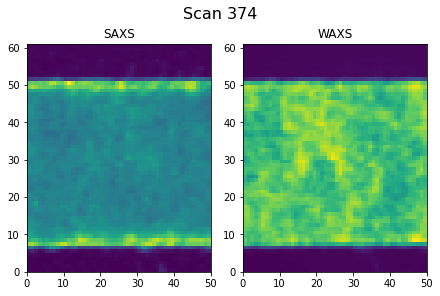

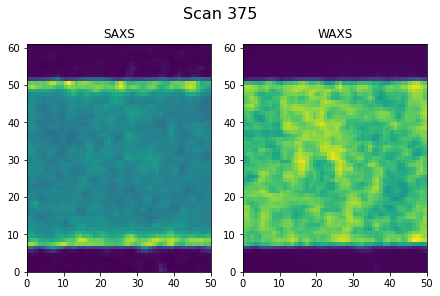

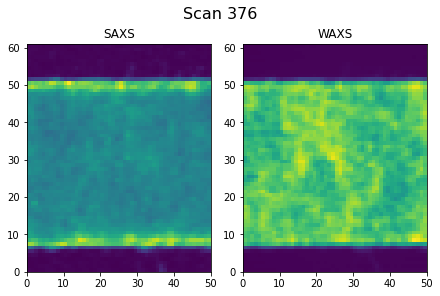

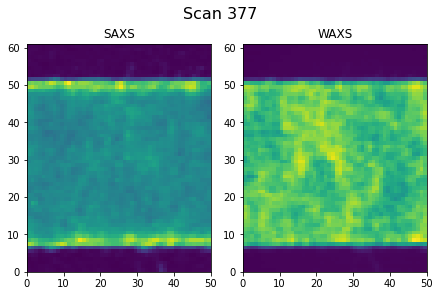

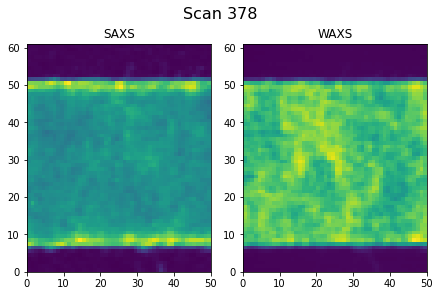

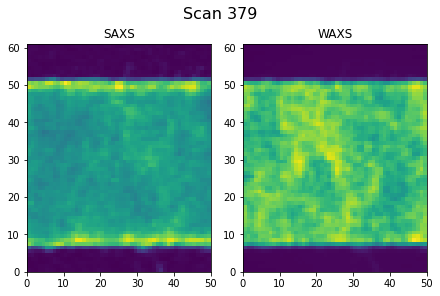

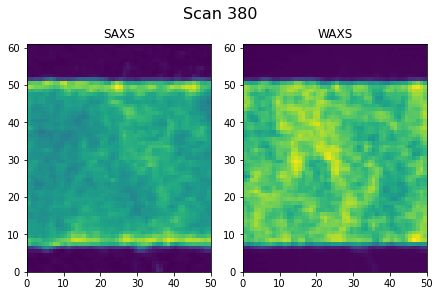

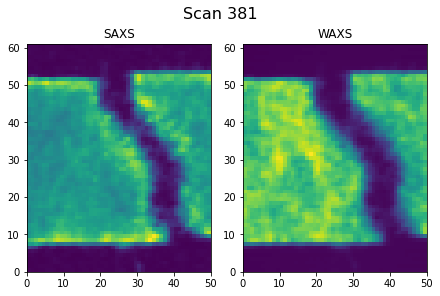

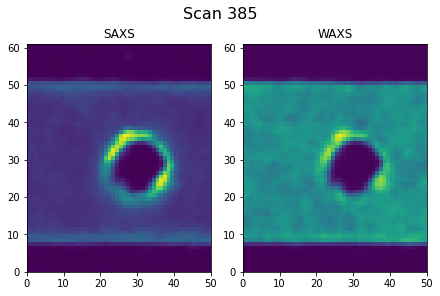

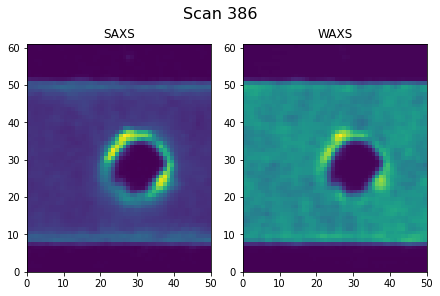

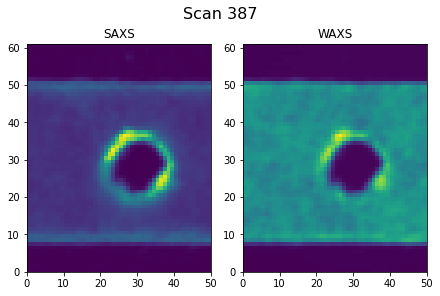

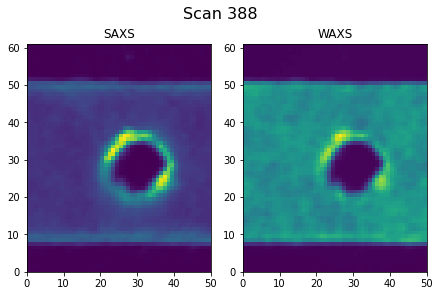

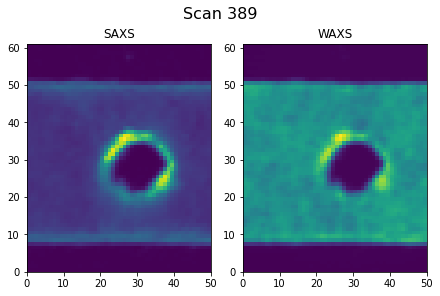

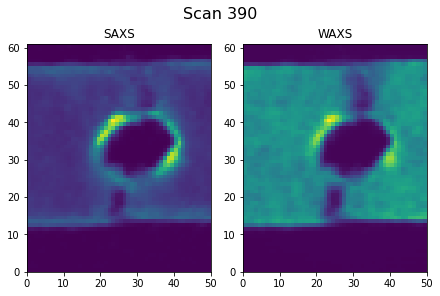

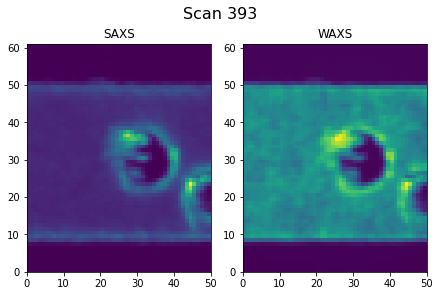

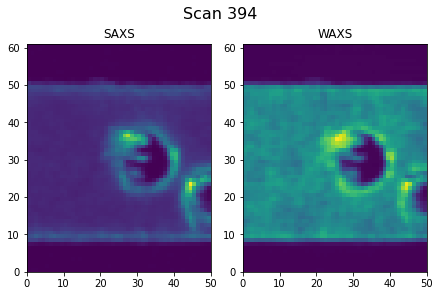

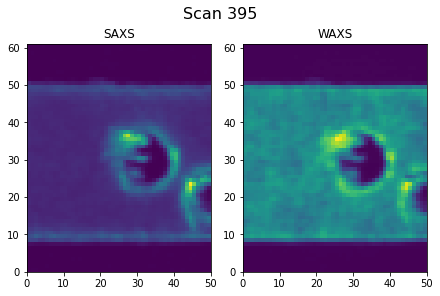

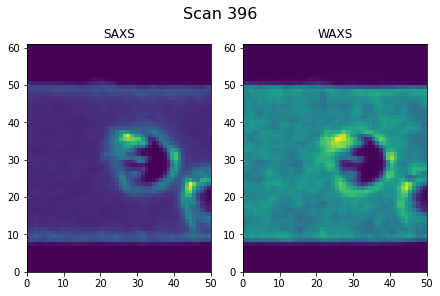

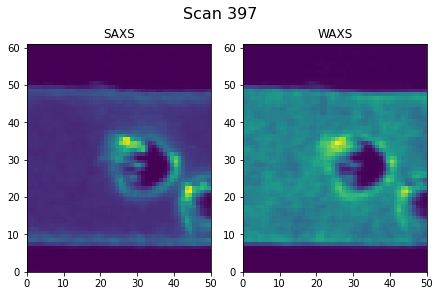

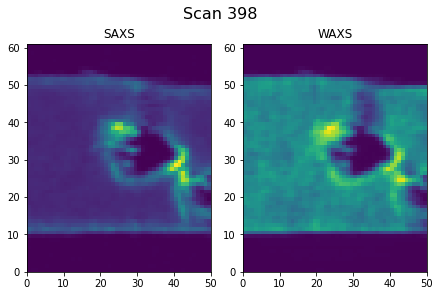

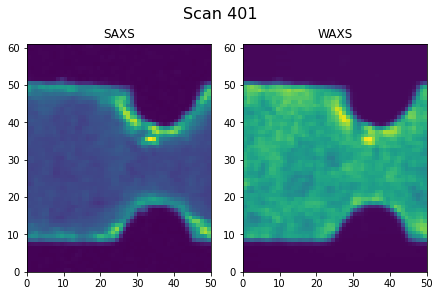

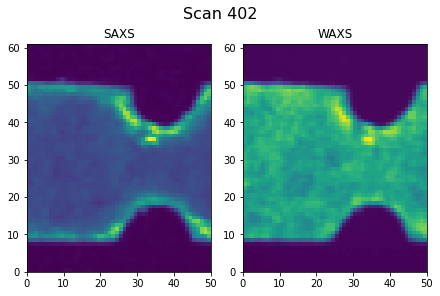

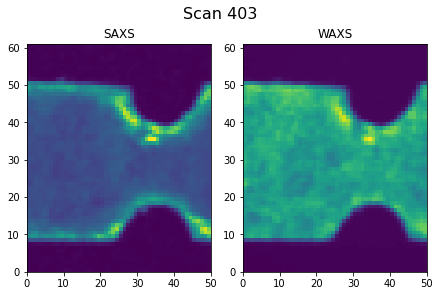

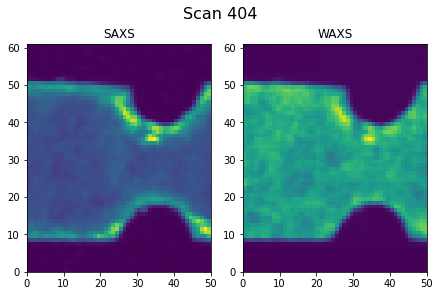

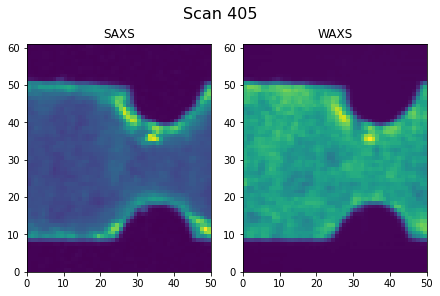

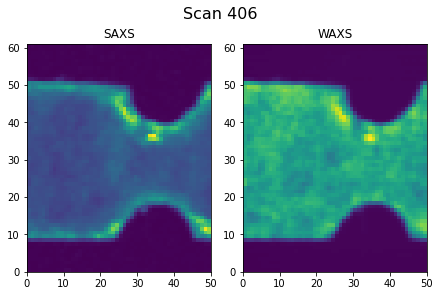

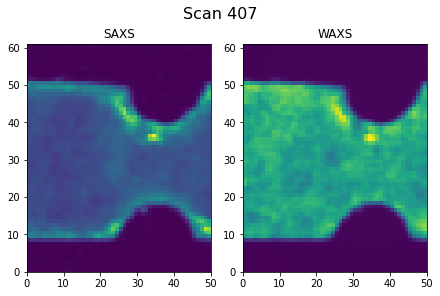

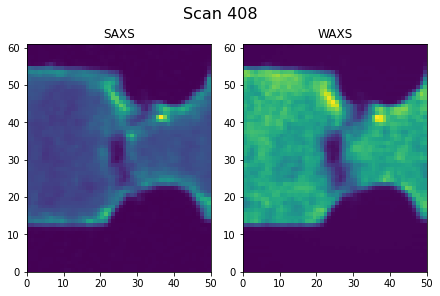

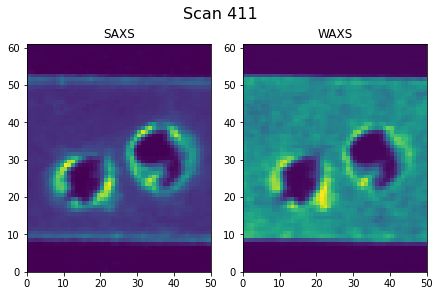

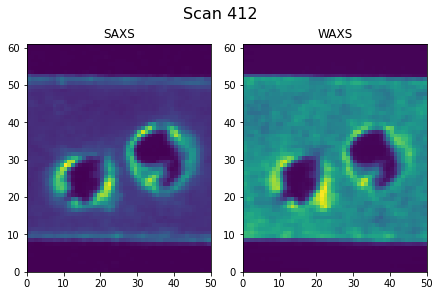

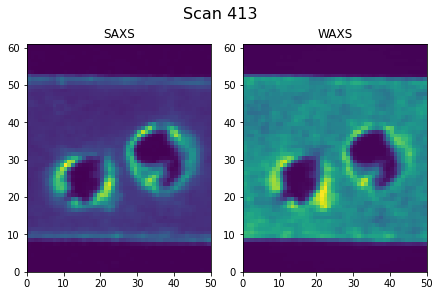

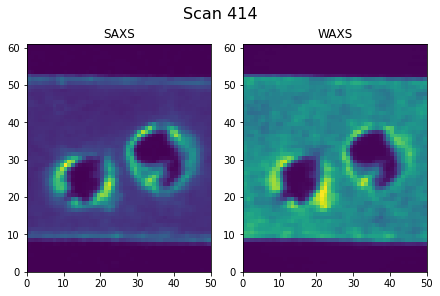

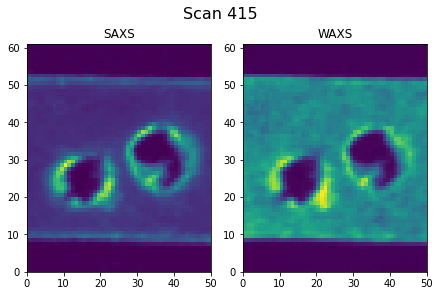

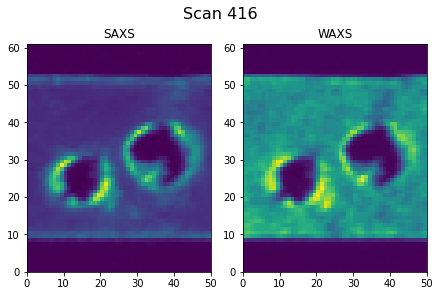

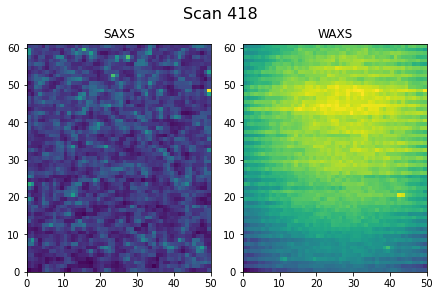

In [13]:
for data in scan_data:
    # timestr = datetime.datetime.fromisoformat(data['timestamp']).strftime('%Y-%m-%d %H:%M:%S')
    # title = 'Scan %d, %s' %(data['scan'], timestr)
    title = 'Scan %d' %(data['scan'])
    filename = 'tot_scatter_scan_%d' %data['scan']
    plot2(title, filename, data['sI'], data['wI'])

In [ ]:

for i, scan in enumerate(scans):
    try:
        absorption, total_scattering, image, endtime = scan_data[i]
        print('plotting scan %d' %scan)
        text = 'Endtime: %s' %(endtime)
        # text = 'Endtime: %s, Temp: %.1f, Hum: %.1f' %(endtime.strftime('%Y-%m-%d %H:%M:%S'), temp, hum)
        print(text)
        plot_data(scan, proposal, visit, det, absorption, total_scattering, image, text)
    except:
        print('Failed to plot scan %d' %scan)
        continue

    

In [ ]:
import pandas as pd
folder ='/data/visitors/formax/%s/%s' %(proposal, visit)

RH_file = 'process/tensile_and_humidity/RH_increase_long.txt'
headers = ['Elap Time','Set Hum','Read Hum','Wet Flow','Dry Flow','Sensor Temp','Used Temp']
RH_data = pd.read_csv(os.path.join(folder, RH_file), delimiter='\t', skiprows=26, names=headers)
# print(RH_data)
RH_data['Datetime'] = pd.to_datetime(RH_data['Elap Time'])
# change the day for the ones after 20:00:00 to the previous day
RH_data.loc[ RH_data['Datetime'].dt.hour >= 20, 'Datetime'] = RH_data['Datetime'] - pd.Timedelta(days=1)
RH_data

In [ ]:
# correlate RH data with scan data
import datetime
scan_times = [data[3] for data in scan_data]
scan_times = [datetime.datetime.fromisoformat(time.decode('utf-8')) for time in scan_times]
scan_times

temps = []
hums = []
for i, time in enumerate(scan_times):
    print(i, time)
    # find the closest time before in RH_data and interpolate the sensor temp and Read Hum
    idx = RH_data[RH_data['Datetime'] < time].index[-1]
    temps.append(RH_data['Sensor Temp'][idx])
    hums.append(RH_data['Read Hum'][idx])

# add the temperature and humidity to the scan data, and replace the time with the scan_times
for i, data in enumerate(scan_data):
    data.append(temps[i])
    data.append(hums[i])
    data[3] = scan_times[i]


In [ ]:
scan_data[0]

In [ ]:

for i, scan in enumerate(scans):
    try:
        absorption, total_scattering, image, endtime, = scan_data[i]
        print('plotting scan %d' %scan)
        text = 'Endtime: %s, Temp: %.1f, Hum: %.1f' %(endtime.strftime('%Y-%m-%d %H:%M:%S'), temp, hum)
        print(text)
        plot_data(scan, proposal, visit, det, absorption, total_scattering, image, text)
    except:
        print('Failed to plot scan %d' %scan)
        continue

    




In [ ]:
# read tensile data


# Orientation analysis

### Data processing

In [ ]:
!pip install pyestimate

In [ ]:

from pyestimate import sin_param_estimate

#Defining angular range for background fitting (to subtract gaps) 
ind_ang = np.array([np.arange(0,26)])


ind_ang1 = np.array([np.arange(0,26)])
ind_ang2 = np.array([np.arange(66,113)])
ind_ang3 = np.array([np.arange(118,180)])

ind_ang = np.concatenate((ind_ang1,ind_ang2),axis=1)
ind_ang = np.concatenate((ind_ang,ind_ang3),axis=1)
print(ind_ang.shape)

#Background subtraction and cropping
data_azi = np.sum(data_scat[:,:,:,ind_q],axis=3) - 0.5*((len(ind_q)/len(ind_bg1))*np.sum(data_scat[:,:,:,ind_bg1],axis=3)+(len(ind_q)/len(ind_bg2))*np.sum(data_scat[:,:,:,ind_bg2],axis=3)) 
data_azi = np.vstack(data_azi)
print(data_azi.shape)




#A,f,phi = sin_param_estimate(data_azi[1000,:])
A,f,phi = sin_param_estimate(data_azi[3000,:])
#A,f,phi = sin_param_estimate(data_azi[5205,:])
#A,f,phi = sin_param_estimate(data_azi[5314,:])

print(A)
print(f)
print(phi)


plt.figure()
#plt.plot(data_azi[1000,:])
#plt.plot(2*ind_ang, data_azi[5205, ind_ang])
plt.plot(2*ind_ang, data_azi[3000, ind_ang])
#plt.plot(data_azi[5314,:])
#plt.plot(A*np.cos(2*np.pi*n*f+phi), 'r--')
plt.title('degree_orient')
plt.ylim([-1000,1000])
plt.show()


